# **Assignment 1: Advanced NLP**

**Author:** Orlando Closs  
**Date:** 23/02/2025
--------------------------------------------------

## Environment setup

Install required packages
```!pip install -r requirements.txt```

Download spaCy model (required for dependency parsing)
```!python -m spacy download en_core_web_md```

If you don't use the requirements.txt file, here are the main dependencies:
```!pip install pandas spacy scikit-learn matplotlib seaborn tqdm nltk benepar```

## Import packages

In [39]:
import pandas as pd
import spacy
from spacy.tokens import Doc
import benepar
from nltk.tree import Tree
from spacy import displacy
import os, logging
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
import joblib

## Data preprocessing

### Process the conllu data

Make class that takes in a .conllu file and returns a dictionary of dataframes, where each dataframe contains the universal probbank data for a sentence.


In [2]:
class ConlluProcessor:

    def __init__(self, file_path): # initialize the class with the file path
        self.file_path = file_path # store the file path
        self.conllu_data = self.read_conllu_file() # read the conllu file and store the data

    def read_conllu_file(self): # define a method to read the conllu file
        """
        reads the conllu file and returns a list of sentences.
        """
        with open(self.file_path, 'r', encoding='utf-8') as file: # open the file with utf-8 encoding
            data = file.read() # read the file content
        return data.split('\n\n') # split the content into sentences

    def sentence_to_dataframe(self, sentence_conllu): # define a method to convert a sentence to a dataframe
        """
        converts a sentence in conllu format to a dataframe.
        """
        columns = ["ID", "WORD", "LEMMA", "POS-UNIV", "POS", "MORPH", "HEAD",  # define the column names
                   "BASIC-DEP", "ENHANCED-DEP", "MISC", "PREDICATE"] # continue defining column names
        rows = [] # initialize an empty list for rows
        sentence_text = '' # initialize an empty string for sentence text
        for row in sentence_conllu.split('\n'): # iterate over each row in the sentence
            if row and row[0].isdigit(): # check if the row is not empty and starts with a digit
                rows.append(row.split('\t')) # split the line by tab and add to rows
            elif row and row[2] == 't': # check if the row is not empty and the third character is 't'
                sentence_text = (row.split('= ')[1]) # extract the sentence text
                
        extra_columns = ["LABELS-P" + str(i+1) for i in range(len(rows[0]) - len(columns))] if rows else [] # create extra columns if needed

        df = pd.DataFrame(rows, columns=columns + extra_columns) # create a dataframe with the rows and columns

        if sentence_text != '': # check if sentence text is not empty
            return df, sentence_text # return the dataframe and sentence text
        else: # if sentence text is empty
            return None # return None

    def conllu_to_dataframes(self): # define a method to convert conllu data to dataframes
        """
        converts a list of sentences in conllu format to a dictionary of dataframes, where each dataframe contains the universal probbank data for a sentence.
        """
        dictionary = {} # initialize an empty dictionary
        for item in self.conllu_data: # iterate over each item in conllu data
            output = self.sentence_to_dataframe(item) # convert the item to a dataframe
            if output == None: # check if the output is None
                continue # skip to the next item
            else: # if output is not None
                dataframe, sentence_text = output # unpack the output
                dictionary[sentence_text] = dataframe # add the dataframe to the dictionary with sentence_text as the key
        return dictionary # return the dictionary

Process test, dev and train data

In [3]:
train_path = './en_ewt-up-train.conllu'
test_path = './en_ewt-up-test.conllu'
dev_path = './en_ewt-up-dev.conllu'

train_processor = ConlluProcessor(train_path)
test_processor = ConlluProcessor(test_path)
dev_processor = ConlluProcessor(dev_path)

train_dataframes = train_processor.conllu_to_dataframes()
test_dataframes = test_processor.conllu_to_dataframes()
dev_dataframes = dev_processor.conllu_to_dataframes()

### Inspect the data

Get the number of sentences in the training and test data, and the average number of words per sentence, average number of predicates per sentence.

In [4]:
print(f"Number of sentences in training data: {len(train_dataframes)}")

print(f"Number of sentences in test data: {len(test_dataframes)}")

print(f"Number of sentences in dev data: {len(dev_dataframes)}")
train_total_tokens = sum(len(df) for df in train_dataframes.values())
print(f"Total number of tokens in training data: {train_total_tokens}")

test_total_tokens = sum(len(df) for df in test_dataframes.values())
print(f"Total number of tokens in test data: {test_total_tokens}")

dev_total_tokens = sum(len(df) for df in dev_dataframes.values())
print(f"Total number of tokens in dev data: {dev_total_tokens}")

train_total_predicates = sum((df['PREDICATE'] != '_').sum() for df in train_dataframes.values())
train_avg_predicates = train_total_predicates / len(train_dataframes)
print(f"Average number of predicates per sentence in training data: {train_avg_predicates:.2f}")

test_total_predicates = sum((df['PREDICATE'] != '_').sum() for df in test_dataframes.values())
test_avg_predicates = test_total_predicates / len(test_dataframes)
print(f"Average number of predicates per sentence in test data: {test_avg_predicates:.2f}")

dev_total_predicates = sum((df['PREDICATE'] != '_').sum() for df in dev_dataframes.values())
dev_avg_predicates = dev_total_predicates / len(dev_dataframes)
print(f"Average number of predicates per sentence in dev data: {dev_avg_predicates:.2f}")


Number of sentences in training data: 11734
Number of sentences in test data: 1971
Number of sentences in dev data: 1914
Total number of tokens in training data: 199246
Total number of tokens in test data: 24728
Total number of tokens in dev data: 24906
Average number of predicates per sentence in training data: 3.36
Average number of predicates per sentence in test data: 2.45
Average number of predicates per sentence in dev data: 2.67


View last item of train data

In [5]:
last_key = list(train_dataframes.keys())[-1] #sentence text
print(last_key)
train_dataframes[last_key] #dataframe

I will never return there again (and now have some serious doubts about the quality of work they actually performed on my car).


,ID,WORD,LEMMA,POS-UNIV,POS,MORPH,HEAD,BASIC-DEP,ENHANCED-DEP,MISC,PREDICATE,LABELS-P1,LABELS-P2,LABELS-P3,LABELS-P4,LABELS-P5
0,1,I,I,PRON,PRP,Case=Nom|Number=Sing|Person=1|PronType=Prs,4,nsubj,4:nsubj|10:nsubj,_,_,ARG1,_,ARG0,_,_
1,2,will,will,AUX,MD,VerbForm=Fin,4,aux,4:aux,_,_,ARGM-MOD,_,_,_,_
2,3,never,never,ADV,RB,_,4,advmod,4:advmod,_,_,ARGM-NEG,_,_,_,_
3,4,return,return,VERB,VB,VerbForm=Inf,0,root,0:root,_,return.01,V,_,_,_,_
4,5,there,there,ADV,RB,PronType=Dem,4,advmod,4:advmod,_,_,ARG4,_,_,_,_
5,6,again,again,ADV,RB,_,4,advmod,4:advmod,_,_,ARGM-TMP,_,_,_,_
6,7,(,(,PUNCT,-LRB-,_,4,punct,4:punct,SpaceAfter=No,_,_,_,_,_,_
7,8,and,and,CCONJ,CC,_,10,cc,10:cc,_,_,_,_,_,_,_
8,9,now,now,ADV,RB,_,10,advmod,10:advmod,_,_,_,_,ARGM-TMP,_,_
9,10,have,have,VERB,VBP,Mood=Ind|Tense=Pres|VerbForm=Fin,4,conj,4:conj:and,_,have.LV,_,V,ARGM-LVB,_,_


### Separating tables with multiple predicates

Ensuring each table only contains one predicate. Also adding a label: format is {predicate}_{sentence} for dictionary keys and removing sentences with no predicates.

In [6]:
def extract_predicates(df): 
    """
    Extracts predicates from a dataframe and returns a list of tuples, where each tuple contains the predicate string and dataframe (duplicate predicate labels).
    """

    output_dfs = []  # list to store output dataframes
    base_cols = list(df.loc[:, "ID":"MISC"].columns)  # columns to keep in the output
    for col in df.columns:
        if col in base_cols or col == "PREDICATE":  # skip base columns and PREDICATE column
            continue

        v_indices = df.index[df[col] == "V"].tolist()  # find indices where the column has 'V'
        for idx in v_indices:
            temp_df = df[base_cols + ["PREDICATE", col]].copy()  # create a temporary dataframe
            temp_df.rename(columns={col: "LABELS-P0"}, inplace=True)  # rename the column to LABELS-P0
            predicate_string = temp_df.loc[idx, "PREDICATE"]  # get the predicate string
            temp_df.loc[temp_df.index != idx, "PREDICATE"] = "_"  # set PREDICATE to '_' for non-matching indices
            temp_df = temp_df[base_cols + ["PREDICATE", "LABELS-P0"]]  # reorder columns
            output_dfs.append((predicate_string, temp_df))  # append the tuple to the output list
        
    return output_dfs  # return the list of tuples

def separate_label_predicates(dataframes):
    """
    Separates predicates from a dataframe and returns a dictionary of dataframes, where each key (sentence) starts with the predicate label.
    Completes the separation of predicates for all dataframes in the dictionary.
    """

    separated_dataframes = {}  # dictionary to store separated dataframes
    for sentence, df in dataframes.items():
        n_predicates = (df == 'V').sum().sum()  # count the number of predicates
        
        if n_predicates > 1:  # if more than one predicate
            output_dfs = extract_predicates(df)  # extract predicates
            for predicate_string, separated_df in output_dfs:
                separated_dataframes[predicate_string+"_"+sentence] = separated_df  # add to dictionary
        elif n_predicates == 0:  # no predicate we do not include it
            continue 
            #separated_dataframes["0_"+sentence] = df  # add to dictionary with label 0
        else:  # exactly one predicate
            predicate_string = df.loc[df['PREDICATE'] != '_', 'PREDICATE'].values[0]  # get the predicate string
            separated_dataframes[predicate_string+"_"+sentence] = df  # add to dictionary
            df.rename(columns={"LABELS-P1": "LABELS-P0"}, inplace=True)  # rename column for consistency

    return separated_dataframes  # return the dictionary of separated dataframes



Apply separating predicates to all dataframes.

In [7]:
processed_test_dataframes=separate_label_predicates(test_dataframes)

processed_train_dataframes=separate_label_predicates(train_dataframes)

processed_dev_dataframes=separate_label_predicates(dev_dataframes)

Inspect the data after separating predicates (each sentence has only one predicate as sentences with multiple predicates have been separated and sentences with no predicates have been removed)

In [8]:
print(f"Number of sentences in training data: {len(processed_train_dataframes)}")

print(f"Number of sentences in test data: {len(processed_test_dataframes)}")

print(f"Number of sentences in dev data: {len(processed_dev_dataframes)}")

train_total_tokens = sum(len(df) for df in processed_train_dataframes.values())
print(f"Total number of tokens in training data: {train_total_tokens}")

test_total_tokens = sum(len(df) for df in processed_test_dataframes.values())
print(f"Total number of tokens in test data: {test_total_tokens}")

dev_total_tokens = sum(len(df) for df in processed_dev_dataframes.values())
print(f"Total number of tokens in dev data: {dev_total_tokens}")

train_total_predicates = sum((df['PREDICATE'] != '_').sum() for df in processed_train_dataframes.values())
train_avg_predicates = train_total_predicates / len(processed_train_dataframes)
print(f"Average number of predicates per sentence in training data: {train_avg_predicates:.2f}")

test_total_predicates = sum((df['PREDICATE'] != '_').sum() for df in processed_test_dataframes.values())
test_avg_predicates = test_total_predicates / len(processed_test_dataframes)
print(f"Average number of predicates per sentence in test data: {test_avg_predicates:.2f}")

dev_total_predicates = sum((df['PREDICATE'] != '_').sum() for df in processed_dev_dataframes.values())
dev_avg_predicates = dev_total_predicates / len(processed_dev_dataframes)
print(f"Average number of predicates per sentence in dev data: {dev_avg_predicates:.2f}")


Number of sentences in training data: 37205
Number of sentences in test data: 4525
Number of sentences in dev data: 4705
Total number of tokens in training data: 931170
Total number of tokens in test data: 94434
Total number of tokens in dev data: 97909
Average number of predicates per sentence in training data: 1.00
Average number of predicates per sentence in test data: 1.00
Average number of predicates per sentence in dev data: 1.00


## Feature extraction

### Feature 1: Compulsory feature

"This is a complex feature integrating: the directed dependency path from the token to the predicate + the predicate’s lemma": Cannot use information from the dataset must assume that it works given any tokenized sentence and the predicate position.

In [9]:
#from SpacyParsing.ipynb tutorial
logger = logging.getLogger("spacy")  # get logger for spacy
logger.setLevel(logging.ERROR)  # set logger level to error
os.environ['TRANSFORMERS_NO_ADVISORY_WARNINGS'] = 'true'  # suppress transformers advisory warnings
#taken from notebook tutorial February 6
# python3 -m spacy download en_core_web_md
nlp = spacy.load("en_core_web_md")  # load spacy model en_core_web_md

**Prepare functions to get complex feature**

This feature is our complex/compulsory feature that gives us a dependency path from each token to the predicate with up and down arrows along with the predicate lemma. 

This is a significant feature for the model as it captures the syntactic relationship between each token and the predicate, encouraging accurate semantic role labeling. The syntactic path between a predicate and its arguments strongly indicates their semantic roles - tokens with similar dependency paths to the predicate will serve similar semantic functions.  We add the predicate lemma because different predicates assign semantic roles differently, even with identical syntactic paths.

To achieve this we will need to find the paths to the root from each token and the predicate, find the lowest common ancestor of the token and the predicate, and then create the path from the token to the ancestor and from the ancestor to the predicate. 

Pseudocode:

```
Features = []

For each token in the sentence:

    Find the dependency path from each token to the root.
    Find the dependency path from the predicate to the root.

    Find the lowest common ancestor of the token and the predicate.

    If the ancestor is the root, then the path is the full path UP from the token to the root and the path DOWN from the root to the predicate.
    If the ancestor is not the root, then the path is the path UP from the token to the ancestor and the path DOWN from the ancestor to the predicate.
    If the predicate is the ancestor, then the path DOWN is empty.

    Add the path and the predicate lemma to the Features list.
```


In [23]:
def get_complex_feature(tokenized_sentence, predicate_position):
    """
    Gets the dependency path from each token to the predicate using LCA (lowest common ancestor) approach.
    Uses ↑ for going up the tree and ↓ for going down.
    """
    doc = nlp(Doc(nlp.vocab, words=tokenized_sentence)) # process the sentence with spaCy
    
    target = doc[predicate_position] # the predicate token we want paths to
    target_lemma = target.lemma_ # get the lemma of the predicate token (used to create feature)
    
    def find_path_to_root(token):  # Function to find path from token to root 
        path = []
        current = token
        while current.head != current: # Continue until we reach the root (a token that is its own head)
            path.append((current, current.dep_))
            current = current.head
        path.append((current, current.dep_))  # Add the root itself
        return path
    
    results = []
    
    for i, token in enumerate(doc): # For each token in the sentence
        if i == predicate_position: # If this is the predicate token itself
            results.append(f"self | {target_lemma}")
            continue
            
        token_to_root = find_path_to_root(token) # find the path from the token to the root
        target_to_root = find_path_to_root(target) # find the path from the predicate to the root
        
        token_indices = [t[0].i for t in token_to_root] # get the indices of the tokens in the path
        target_indices = [t[0].i for t in target_to_root] # get the indices of the predicate tokens in the path
        
        # Find the LCA (first common ancestor in both paths)
        #https://www.geeksforgeeks.org/lowest-common-ancestor-binary-tree-set-1/
        lca_found = False 
        for i, token_idx in enumerate(token_indices):
            if token_idx in target_indices: #ancestor found (could be the root)
                j = target_indices.index(token_idx) #get the index of the ancestor, will be 0 if ancestor is the predicate
                lca_found = True #set the flag to true
                
                path_up = [f"↑{t[1]}" for t in token_to_root[:i]] #path up from token to ancestor, if ancestor is the root then the path is full (up and down)
                
                path_down = [f"↓{t[1]}" for t in reversed(target_to_root[:j])] #path down from ancestor to predicate, if ancestor is the predicate then the path is empty
                
                final_path = "".join(path_up + path_down) #combine the paths
                results.append(f"{final_path} | {target_lemma}") #add the path and predicate lemma to the results
                break
        if not lca_found:
            results.append(f"nopath | {target_lemma}") #if no path found then add no path to the results (shouldnt happen due to root but may need to debug spacy errors)
    
    return results

Test the functions

In [24]:
tokenized_sentence = ["I", "broke", "the", "window", "with", "the", "panda", "sticker"] #example sentence (tokenized)
predicate_position = 1 # 'broke' is the predicate
dependency_paths = get_complex_feature(tokenized_sentence, predicate_position) #use function to get dependency paths
print(dependency_paths)

['↑nsubj | break', 'self | break', '↑det↑dobj | break', '↑dobj | break', '↑prep | break', '↑det↑pobj↑prep | break', '↑compound↑pobj↑prep | break', '↑pobj↑prep | break']


### Feature 2: Lemma

**Token lemma**

This feature complements our complex feature by focusing on the semantic content of each token. While the dependency paths capture structural relationships, lemmas help the model recognize semantically similar arguments across different sentences, even when they appear in different syntactic contexts. For instance, terms like "vehicle", "car", and "truck" as lemmas would help the model identify similar semantic roles despite varying sentence structures.


In [25]:
def get_lemma_feature(tokenized_sentence):
    """
    Creates a feature using just the lemma (base form) of each token.
    """
    doc = nlp(Doc(nlp.vocab, words=tokenized_sentence))  # Process with spaCy to get lemmas
    
    features = []
    for token in doc:
        features.append(token.lemma_)
    
    return features

tokenized_sentence = ["I", "broke", "the", "window", "with", "the", "panda", "sticker"]
lemma_features = get_lemma_feature(tokenized_sentence)
print(lemma_features)

['I', 'break', 'the', 'window', 'with', 'the', 'panda', 'sticker']


### Feature 3: POS Tag

**pos tag**

Part-of-speech tags provide grammatical category information that complements both our syntactic path and lemma features. POS tags help identify potential semantic roles independent of specific word choices - for example, nouns often serve as arguments while adjectives typically don't and proper nouns (PROPN) frequently function as agents.


In [26]:
def get_pos_feature(tokenized_sentence):
    """
    Creates a feature using just the part-of-speech tag for each token.
    """
    doc = nlp(Doc(nlp.vocab, words=tokenized_sentence))
    
    features = []
    for token in doc:
        features.append(token.pos_)
    
    return features

tokenized_sentence = ["I", "broke", "the", "window", "with", "the", "panda", "sticker"]
pos_features = get_pos_feature(tokenized_sentence)
print(pos_features)

['PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'NOUN']


## Prepare features and labels for logistic regression

For each sentence in the dataset we will create a list of tokens and the gold target (SRL label). We will then prepare the features using the previously defined functions. For every feature, token and label in each sentence we will then store in a bigger list representing the whole dataset. 

We will then make the features one hot encoded and the labels encoded with LabelEncoder. The encoders must use only the training data to fit.

In [27]:
class FeatureLabelPreparer:
    def __init__(self, dataframes):
        self.dataframes = dataframes

    def prepare_features_labels(self):
        """
        Prepare features and labels verbosely. Takes the target label (argument) from dataframe and creates a list of features and labels.
        """
        feature1 = []  # initialize empty list to store features
        feature2 = []  # initialize empty list to store features
        feature3 = []  # initialize empty list to store features
        labels = []  # initialize empty list to store labels
        tokens_all = []  # initialize empty list to store tokens
        
        for sentence, df in tqdm(self.dataframes.items(), desc="Processing sentences"):  # iterate over each sentence and its dataframe, tqdm shows progress
            # if sentence[0] == '0':  # check if the sentence starts with '0'
            #     continue  # skip the sentence if it starts with '0' (no predicate)
            # else:
            tokens = []  # initialize empty list to store tokens of the current sentence
            for index, row in df.iterrows():  # iterate over each row in the dataframe
                if row['LABELS-P0'] == '_' or row['LABELS-P0'] == 'V' or row['LABELS-P0'] == '':  # check the label in 'LABELS-P0' column
                    labels.append('O')  # target label is 'O' if predicate or non argument
                else:
                    labels.append(row['LABELS-P0'])  # append the actual label otherwise
                tokens.append(row['WORD'])  # append the word to the tokens list
                tokens_all.append(row['WORD']) # append the token to the tokens list
            #get complex feature
            predicate_position = df[df['LABELS-P0'] == 'V'].index[0]  # find the position of the predicate
            complex_features = get_complex_feature(tokens, predicate_position)  # get dependency paths for the sentence
            for feature in complex_features:  # iterate over each token and its path
                feature1.append([feature])  # create complex feature and append to features

            lemma_features = get_lemma_feature(tokens)
            for feature in lemma_features:
                feature2.append([feature])
            pos_features = get_pos_feature(tokens)
            for feature in pos_features:
                feature3.append([feature])
            # if len(complex_features) != len(tokens) or len(lemma_features) != len(tokens) or len(pos_features) != len(tokens):
            #     print(f"Sentence: {sentence, len(complex_features), len(lemma_features), len(pos_features), len(tokens)}")
            #     print(f"Complex features: {complex_features}")
            #     print(f"Lemma features: {lemma_features}")
            #     print(f"POS features: {pos_features}")
            #     print(f"Tokens: {tokens}")
    
            #     break
        return feature1, feature2, feature3, labels, tokens_all  # return the lists of features and labels

    def prepare_encoders(self, feature1, feature2, feature3, labels):
        """
        Prepares one hot encoding model for features and labels.
        """
        one_hot_encoder_feature1 = OneHotEncoder(handle_unknown='ignore')
        one_hot_encoder_feature2 = OneHotEncoder(handle_unknown='ignore')
        one_hot_encoder_feature3 = OneHotEncoder(handle_unknown='ignore')
        label_encoder = LabelEncoder()

        one_hot_encoder_feature1.fit(feature1)  # fit the encoder for features
        one_hot_encoder_feature2.fit(feature2)  # fit the encoder for features
        one_hot_encoder_feature3.fit(feature3)  # fit the encoder for features
        label_encoder.fit(labels)  # fit the encoder for labels
        feature_encoders = [one_hot_encoder_feature1, one_hot_encoder_feature2, one_hot_encoder_feature3]
        return feature_encoders, label_encoder  # return the fitted encoders

    def transform_features_labels(self, feature1, feature2, feature3, labels, feature_encoders, label_encoder):
        """
        Transforms features and labels using one hot encoding model.
        """
        one_hot_encoded_feature1 = feature_encoders[0].transform(feature1)  # transform features using encoder
        one_hot_encoded_feature2 = feature_encoders[1].transform(feature2)  # transform features using encoder
        one_hot_encoded_feature3 = feature_encoders[2].transform(feature3)  # transform features using encoder

        #deal with unseen labels
        processed_labels = []
        for label in labels:
            if label in label_encoder.classes_:
                processed_labels.append(label)
            else:
                processed_labels.append('O')
                
        encoded_labels = label_encoder.transform(processed_labels)  # transform labels using label encoder
        encoded_features = hstack([one_hot_encoded_feature1, one_hot_encoded_feature2, one_hot_encoded_feature3])
        return encoded_features, encoded_labels  # return combined features and labels

    def train_model(self): #creates a new encoder for each feature and label encoder 
        feature1, feature2, feature3, labels, train_tokens = self.prepare_features_labels()
        feature_encoders, label_encoder = self.prepare_encoders(feature1, feature2, feature3, labels)
        train_encoded_features, train_encoded_labels = self.transform_features_labels(feature1, feature2, feature3, labels, feature_encoders, label_encoder)
        return train_encoded_features, train_encoded_labels, train_tokens, feature_encoders, label_encoder
    
    def test_model(self, feature_encoders, label_encoder): #uses existing encoders to transform features and labels
        feature1, feature2, feature3, labels, tokens = self.prepare_features_labels()
        encoded_features, encoded_labels = self.transform_features_labels(feature1, feature2, feature3, labels, feature_encoders, label_encoder)
        return encoded_features, encoded_labels, tokens


## Scikit learn logistic regression

### Training

In [28]:
trainSet = FeatureLabelPreparer(processed_test_dataframes)
train_encoded_features, train_encoded_labels, train_tokens, feature_encoders, label_encoder = trainSet.train_model()

Processing sentences: 100%|██████████| 4525/4525 [01:00<00:00, 74.41it/s] 


In [29]:
# logistic_regression_model = LogisticRegression(max_iter=1000)  # initialize logistic regression model with max_iter=1000, which means the model will perform a maximum of 1000 iterations to converge

#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
logistic_regression_model = LogisticRegression(        
    solver='saga',        # best for multi-class classification (scikit-learn documentation)
    max_iter=2000,        # higher than default to ensure convergence
)
logistic_regression_model.fit(train_encoded_features, train_encoded_labels)  # fit logistic regression model with features and class indices

LogisticRegression(max_iter=2000, solver='saga')

In [40]:
joblib.dump(logistic_regression_model, 'logistic_regression_model.pkl') # Save the logistic regression model to a file

['logistic_regression_model.pkl']

## Test set

In [30]:
testSet = FeatureLabelPreparer(processed_test_dataframes)
test_encoded_features, test_encoded_labels, test_tokens = testSet.test_model(feature_encoders, label_encoder)
predicted_test_labels = logistic_regression_model.predict(test_encoded_features)  # predict class indices using logistic regression model

Processing sentences: 100%|██████████| 4525/4525 [01:01<00:00, 73.42it/s] 


Make verbose gold and predicted labels, sort out None values in gold labels 'O'

In [31]:
gold_labels_test = [label if label is not None else 'O' for label in label_encoder.inverse_transform(test_encoded_labels)]
predicted_labels_test = [label if label is not None else 'O' for label in label_encoder.inverse_transform(predicted_test_labels)]

Generate classification report

In [32]:
classification_report_str = classification_report(gold_labels_test, predicted_labels_test) # Generate a classification report

print("Classification Report:\n", classification_report_str)

Classification Report:
               precision    recall  f1-score   support

        ARG0       0.91      0.50      0.64      1680
        ARG1       0.89      0.52      0.66      3071
    ARG1-DSP       0.00      0.00      0.00         4
        ARG2       0.86      0.52      0.65      1031
        ARG3       1.00      0.11      0.20        71
        ARG4       0.79      0.47      0.59        55
        ARG5       0.00      0.00      0.00         1
        ARGA       0.00      0.00      0.00         1
    ARGM-ADJ       0.86      0.28      0.42       223
    ARGM-ADV       0.77      0.17      0.28       475
    ARGM-CAU       0.60      0.07      0.12        44
    ARGM-COM       0.00      0.00      0.00        13
    ARGM-CXN       0.00      0.00      0.00        12
    ARGM-DIR       0.75      0.06      0.12        47
    ARGM-DIS       0.88      0.28      0.42       175
    ARGM-EXT       1.00      0.17      0.28       103
    ARGM-GOL       0.00      0.00      0.00        24
   

/mnt/nvme0n1p1/elective/advanced-nlp/ass1/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/nvme0n1p1/elective/advanced-nlp/ass1/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/nvme0n1p1/elective/advanced-nlp/ass1/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Confusion matrix 

Using LogNorm to normalize confusion matrix values to make them more readable. This is because 'O' has an overwhelming number of values in the matrix, making it difficult to see the other values if linear.

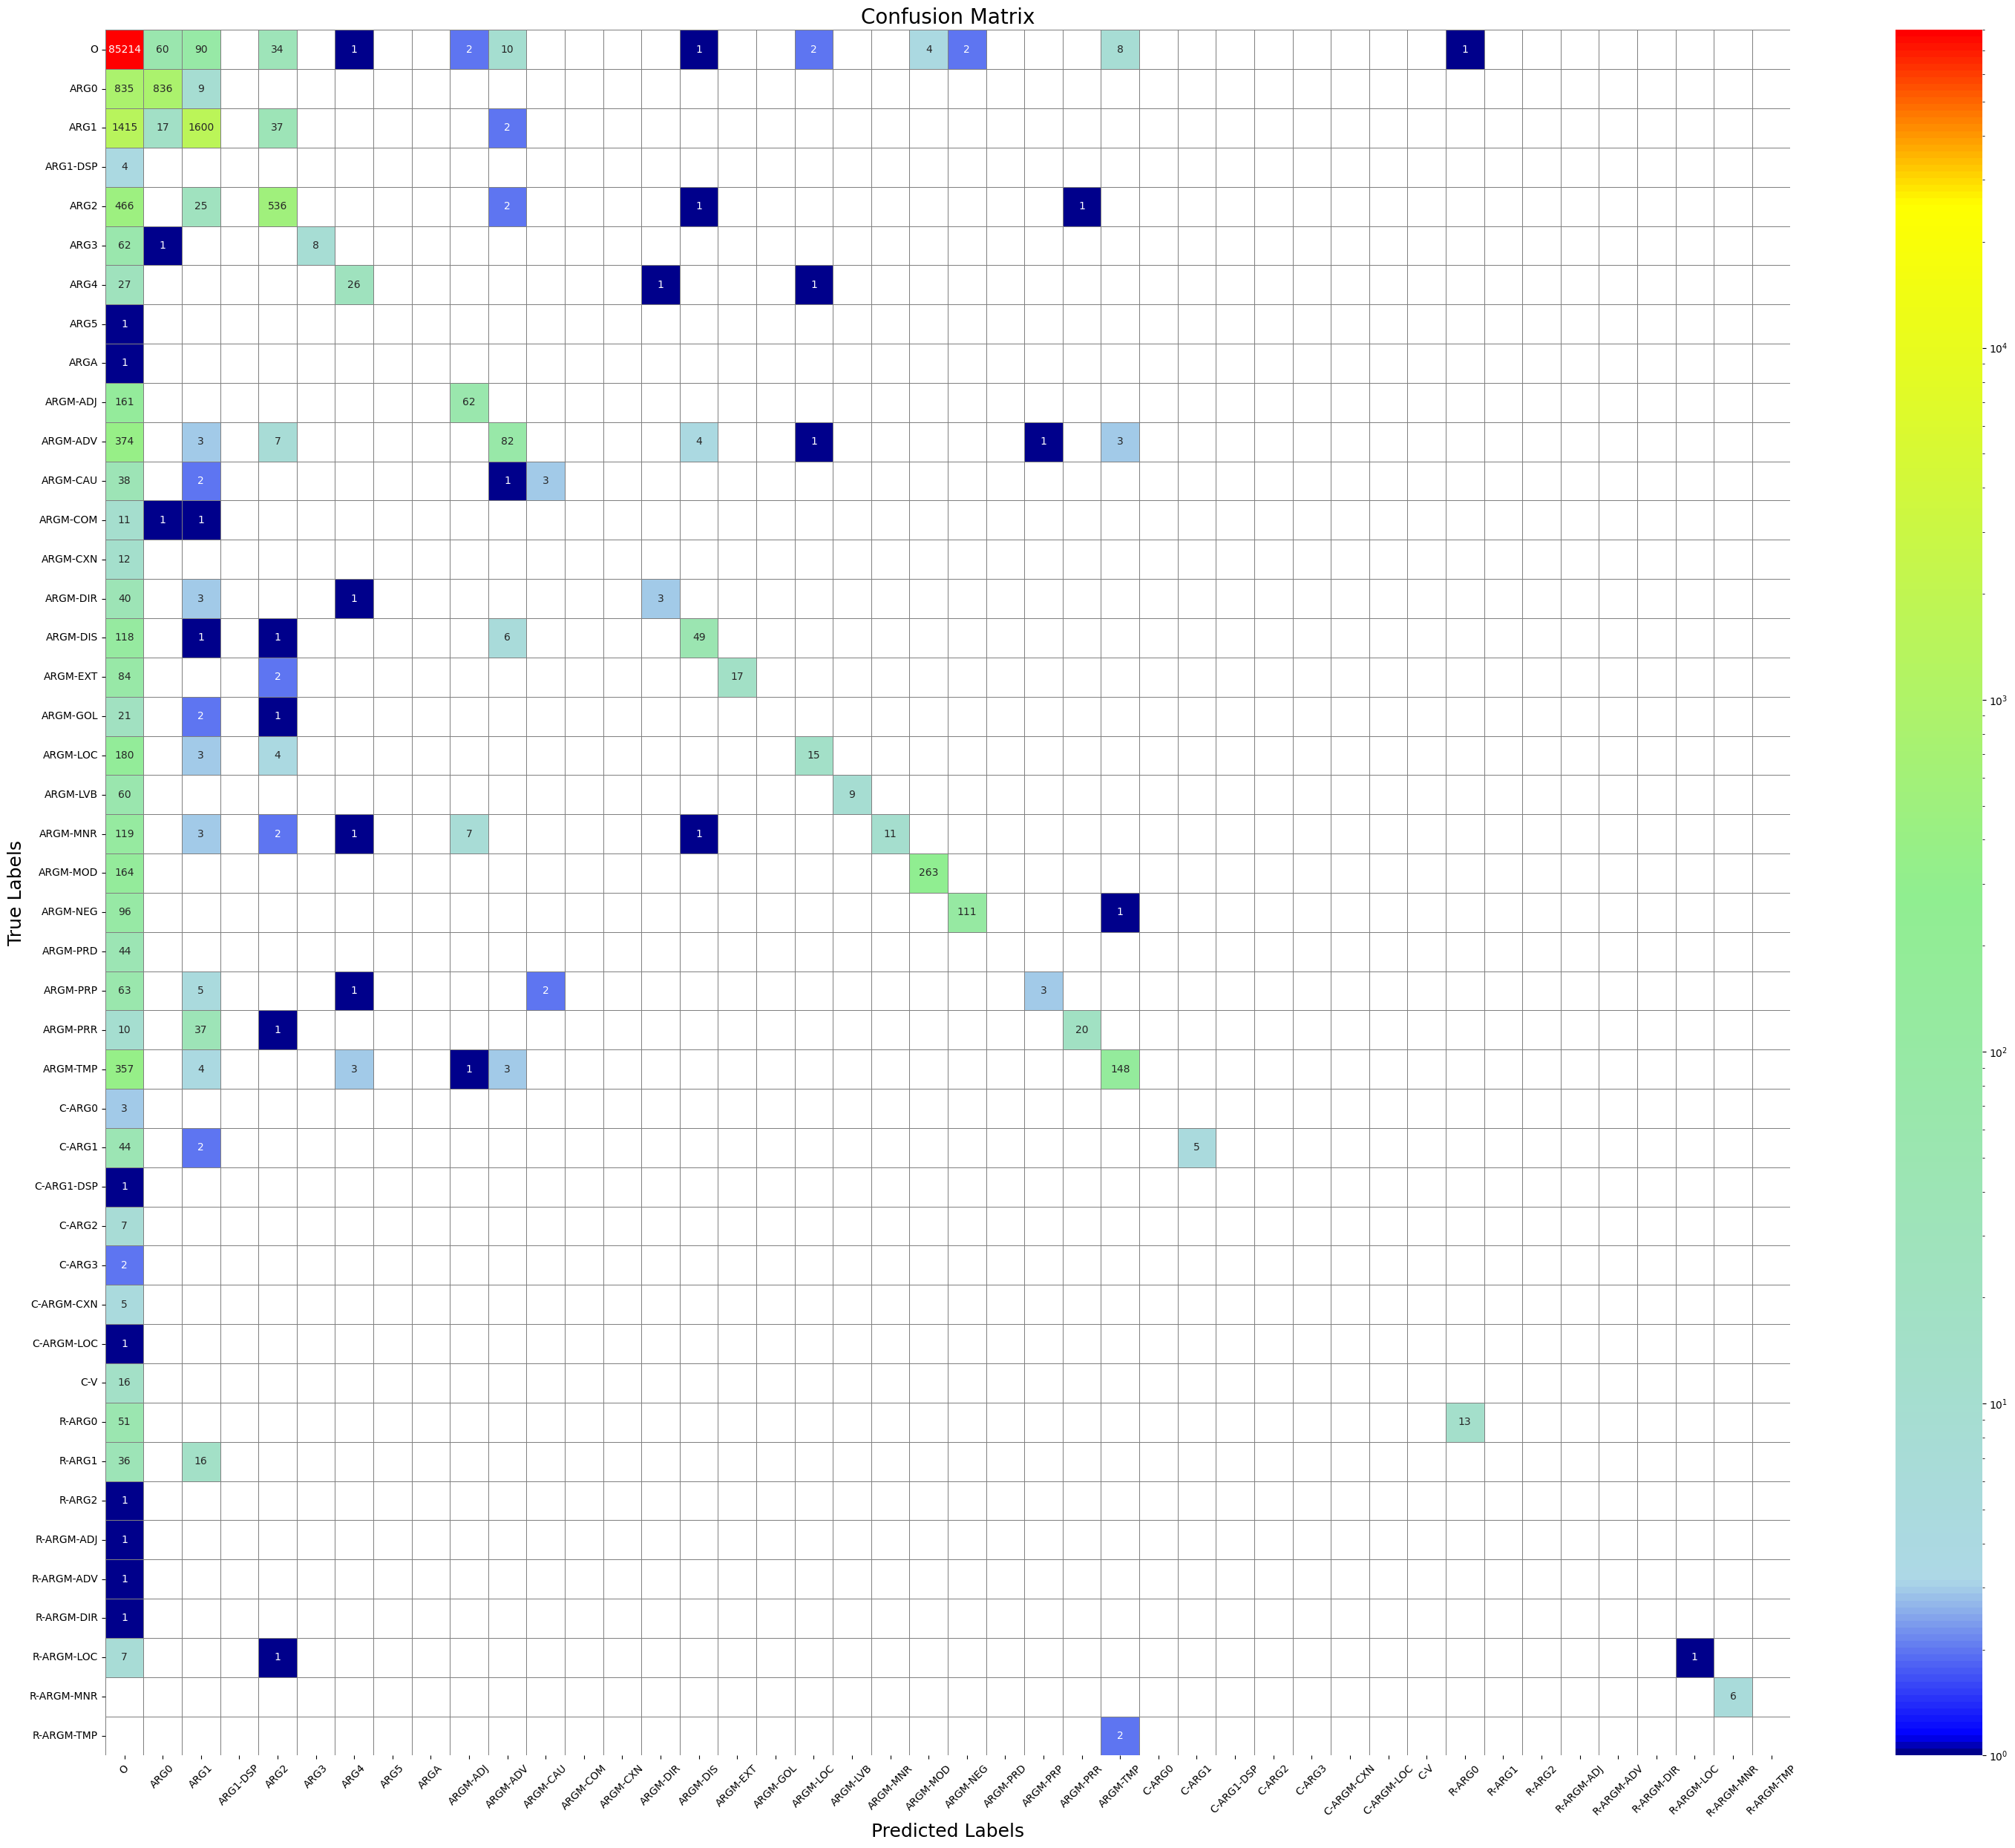

In [33]:
categories = list(label_encoder.classes_)  # get class labels directly from the LabelEncoder
# Handle None values without creating duplicates
if None in categories:
    # Remove None from categories
    categories.remove(None)
# Ensure 'O' is the first category
if 'O' in categories:
    categories.remove('O')
categories.insert(0, 'O')

conf_matrix = confusion_matrix(gold_labels_test, predicted_labels_test, labels=categories)  # generate confusion matrix using gold and predicted labels
colors = [(0.0, "darkblue"), (0.01, "blue"), (0.1, "lightblue"), (0.5, "lightgreen"), (0.9, "yellow"), (1.0, "red")]  # define custom colormap with gradient from darkblue to red
custom_cmap = LinearSegmentedColormap.from_list("sharp_start", colors)  # create a colormap from the defined colors
plt.figure(figsize=(30, 25))  # set the figure size for the plot
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_cmap, xticklabels=categories, yticklabels=categories, norm=LogNorm(vmin=1, vmax=80000), linewidths=0.5, linecolor='grey')  # plot heatmap with log normalization and grid lines
for i in range(len(categories)):  # iterate over categories to highlight specific values
    for j in range(len(categories)):  # iterate over categories for each row
        if conf_matrix[i, j] in [200, 2500, 80000]:  # check if the value is one of the specified values to highlight
            plt.text(j + 0.5, i + 0.5, conf_matrix[i, j], color='red', ha='center', va='center', fontsize=12, fontweight='bold')  # highlight the value in red
plt.xlabel('Predicted Labels', fontsize=18)  # set x-axis label with font size
plt.ylabel('True Labels', fontsize=18)  # set y-axis label with font size
plt.title('Confusion Matrix', fontsize=20)  # set the title of the plot with font size
plt.xticks(rotation=45)  # rotate x-axis labels for better readability
plt.tight_layout()  # adjust layout to prevent overlap
plt.show()  # display the plot


Save output of models predictions

In [34]:
output_df = pd.DataFrame({
    'Token': test_tokens,
    'Gold Label': gold_labels_test,
    'Predicted Label': predicted_labels_test
})
output_df.to_csv('test_predictions.csv', index=False)


## Stand alone function

Input is tokenized sentence, predicate positions (binary list), model, feature encoders and label encoder. For multiple predicates in the sentence, the function will return a list of lists as cannot combine arguments for multiple predicates in the same list (as done in the original conll dataset). We will also readd the 'V' for predicate concerned.

In [35]:
def standalone_function(tokenized_sentence, predicate_indicators, model, feature_encoders, label_encoder):
    """
    This function takes a tokenized sentence and a list of predicate indicators (0=not predicate, 1=predicate)
    and returns the predicate labels for all tokens for each predicate.
    """
    # Find all predicate positions from the indicators
    predicate_positions = [i for i, indicator in enumerate(predicate_indicators) if indicator == 1]
    
    if not predicate_positions:
        return []  # No predicates found
    
    all_predictions = []
    
    for predicate_position in predicate_positions: #process each predicate
        # Feature 1: Complex feature
        complex_features = get_complex_feature(tokenized_sentence, predicate_position)
        complex_features = [[feature] for feature in complex_features]
        
        # Feature 2: Lemma feature
        lemma_features = get_lemma_feature(tokenized_sentence)
        lemma_features = [[feature] for feature in lemma_features] 
        
        # Feature 3: POS feature
        pos_features = get_pos_feature(tokenized_sentence)
        pos_features = [[feature] for feature in pos_features]
        
        # Transform features
        encoded_feature1 = feature_encoders[0].transform(complex_features)
        encoded_feature2 = feature_encoders[1].transform(lemma_features)
        encoded_feature3 = feature_encoders[2].transform(pos_features)
        features = hstack([encoded_feature1, encoded_feature2, encoded_feature3])
        
        predicted_labels = model.predict(features) #predict labels for each predicate
        predicted_labels = [label if label is not None else 'O' for label in label_encoder.inverse_transform(predicted_labels)]
        
        predicted_labels[predicate_position] = 'V' # Add the predicate role marker at the predicate position
        
        all_predictions.append(predicted_labels)
    
    return all_predictions

In [37]:
tokenized_sentence = ["John", "bought", "a", "car", "and", "drove", "it", "to", "work", "."]
predicate_indicators = [0, 1, 0, 0, 0, 1, 0, 0, 0, 0]
print(standalone_function(tokenized_sentence, predicate_indicators, logistic_regression_model,  feature_encoders, label_encoder))

[['ARG0', 'V', 'O', 'ARG1', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'V', 'O', 'O', 'O', 'O']]
